#PyTorch WorkFlow
1. Data(prepare and load)
2. bulid model
2. Fitting the model to data(training)
3. making the prediction and evaluating a model(inference)
4. saving and loading a model
5. putting it all together

```
Author: Keahi Xie

Date: 30 Dec. 2023
```

In [147]:
import torch
from torch import nn # nn contain all of PyTorch's buliding blok for nerual networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__



'2.1.0+cu121'

## 1. Data (preparing and loading)
Data can be almost anything... in machine learning
* Excal speadsheet
* Images of any kind
* Video
* Audio
* DNA (I like this ones)
* Text


Maching learning is a game of two parts:
1. Get data into a numerical representatioin.
2. Bulid a model to learn patterns in that numerical representatioin.


In [148]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting data into traininng and test sets(one of the most important concepts in machine learing in general)

Let's create a trainning and test set with out dataset

In [149]:
#Create a train / test split
train_split = int(0.8 * len(X))
Xtrain,ytrain = X[:train_split],y[:train_split]
Xtest,ytest = X[train_split:], y[train_split:]
len(Xtrain),len(ytrain),len(Xtest)

(40, 40, 10)

How might we better visualize out data?

This is where the data explorer's mdoel comes in!

"Visualize, visualize, visualize!"


## 2. Bulid model
Our first PyTorch model!

In [150]:
from torch import nn

#Create liner regression model class
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weight = nn.Parameter(torch.randn(1,
                                           requires_grad=True,
                                           dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                           requires_grad=True,
                                           dtype=torch.float))
  # Forward method to define the computation in the model
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.weight * x +self.bias

In [151]:
def plot_predictions(train_data = Xtrain,
                 train_labels = ytrain,
                 test_data = Xtest,
                 test_labels = ytest,
                 predictions = None):
  plt.figure(figsize = (10,7))

  #Plot training data in bule

  plt.scatter(train_data, train_labels, c ='b', s= 4, label = "Training data")
  plt.scatter(test_data, test_labels, c = 'g', s= 4, label = "Testing data")
  if predictions is not None:
    plt.scatter(test_data, predictions, c ='r', s = 4, label = "Predictions")
  plt.legend(prop={"size": 14})

### PyTorch model buliding essentials

* `torch.nn` - contains all of the buildings for computiaonal graphs(a neural network can be considered a computational graph)
* `torch.nn.Parameter` - waht parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* `torch.nn.Module` - The base class for all neural network modules, if you subclass it, you should overwrite `forward()`
* `torch.optim` - this where the optimizers in PyTorch live, that wille help me to do gradient descent
* `def forward()` - all nn.module subclasses **require** you to overwrite forward(), this method defines what happens in the forward computation

### Checking the contens of our PyTorch model
Now we've created a model, let'see what;s inside...
So we can check our model parameters or what's inside our model using `.parameters()`

In [152]:
# Create a random seed
torch.manual_seed(77)

# Create an instance of the model(this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

 # Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([-0.3568], requires_grad=True),
 Parameter containing:
 tensor([0.6007], requires_grad=True)]

In [153]:
# List named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([-0.3568])), ('bias', tensor([0.6007]))])

In [154]:
 weight, bias

(0.7, 0.3)

### Making prediction using  `torch.inference_mode_()`
To check model' predictive power, let's see how well it predicts `y_test` baesd on `X_test `

When we pass data through our model, It's going to run it through the `forward` method

In [155]:
# Make predictions with model (2 different way)
# Way 1 : Use `torch.inference_mode()', dont have graident desence
with torch.inference_mode():
  y_preds = model_0(Xtest)

# Your can also do something similar with torch.no_grad(), however, `torch.inference_mode` is more preferred

In [156]:
# Way 2 : directly use model trained to do predict
y_pred = model_0(Xtest)
y_pred

tensor([[0.3153],
        [0.3081],
        [0.3010],
        [0.2938],
        [0.2867],
        [0.2796],
        [0.2724],
        [0.2653],
        [0.2582],
        [0.2510]], grad_fn=<AddBackward0>)

In [157]:
ytest

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

## 3. Train model
The whole of trainning is for model to move from *unknown* parameters(these may be random) to some *known* parameters.

Or in other words a poor representation of the data to a better representation of the data.

One way to measure how poor or how wrong your models  predictions are is use a loss function

* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function.

Thing we need to train:
* **Loss function**: A function to measure how wrong your model's predictions are the idel ouput, lower is better.
* **Optimizer**: Takes into account the loss of a model and adjust the model's parameters(e.g. weight and bias in our case) to improve the loss function.
  * Inside the optimizer you'll often have to set two parameters:
    * `params`- the model parameters you'd like to optimize.
    * `lr` - the learning rate is a hyperparameter that defines how big/small the optimizer changes the parameters with ecah step.

And specifically for PyTorch, we need:
* A trainning loop
* A testing loop

How to check your parameters during training:
* `list(model.parameters())`
* `model.state_dict()`

In [158]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup a optimizer
optimizer = torch.optim.SGD(params= model_0.parameters(),
                            lr = 0.025)

### Building a training loop (and a testing loop) in PyTorch

A couple of thing we need in a training loop:
1. Loop through the data
2. Forward pass(this invovles data moving through our model's `forward()` function - also called forward propagation)
3.  Calculate the loss(compare forward pass prediction to groubd truth labels)
4. Pptimizer zero grad
5. Loss backward - move backwards through the network to calculate the gradients of each the parameters of our model with respect to the loss
6. optimizer step - use the optimizer to adjust our model's parameters to tray and improve the loss

In [159]:
# An epoch is one loop through the data...(this is hyperparameter beacasue we've set itself)
epochs = 250

### Track the traning and testing loss
epoch_count = []
train_loss_values = []
test_loss_values = []
### Trainning
# 0. Loop through the data
for epoch in range(epochs):
  #Set the model to tranning mode
  model_0.train() # train mode in PyTorch sets all parametrs that require gradient

  # 1. Forward pass
  y_pred = model_0(Xtrain)

  # 2. calculate the loss
  loss = loss_fn(y_pred, ytrain)


  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. Preform backpropagation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. Step the optimizer (preform gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval() # turn off the gradient tracking
  with torch.inference_mode():
    # 1. do the forward pass
    test_pred = model_0(Xtest)

    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, ytest)

  if epoch % 10 == 0:
    epoch_count.append(epoch)
    train_loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch:{epoch} | Loss:{loss}| Tess Loss:{test_loss}")
    print(model_0.state_dict())

Epoch:0 | Loss:0.2260170727968216| Tess Loss:0.6272676587104797
OrderedDict([('weight', tensor([-0.3497])), ('bias', tensor([0.6070]))])
Epoch:10 | Loss:0.20029732584953308| Tess Loss:0.5285012125968933
OrderedDict([('weight', tensor([-0.2851])), ('bias', tensor([0.6482]))])
Epoch:20 | Loss:0.1871725469827652| Tess Loss:0.46899086236953735
OrderedDict([('weight', tensor([-0.2309])), ('bias', tensor([0.6595]))])
Epoch:30 | Loss:0.17748413980007172| Tess Loss:0.42957592010498047
OrderedDict([('weight', tensor([-0.1824])), ('bias', tensor([0.6557]))])
Epoch:40 | Loss:0.16875913739204407| Tess Loss:0.4020261764526367
OrderedDict([('weight', tensor([-0.1374])), ('bias', tensor([0.6432]))])
Epoch:50 | Loss:0.16003409028053284| Tess Loss:0.37447649240493774
OrderedDict([('weight', tensor([-0.0924])), ('bias', tensor([0.6307]))])
Epoch:60 | Loss:0.15140508115291595| Tess Loss:0.3520784378051758
OrderedDict([('weight', tensor([-0.0489])), ('bias', tensor([0.6145]))])
Epoch:70 | Loss:0.142808079

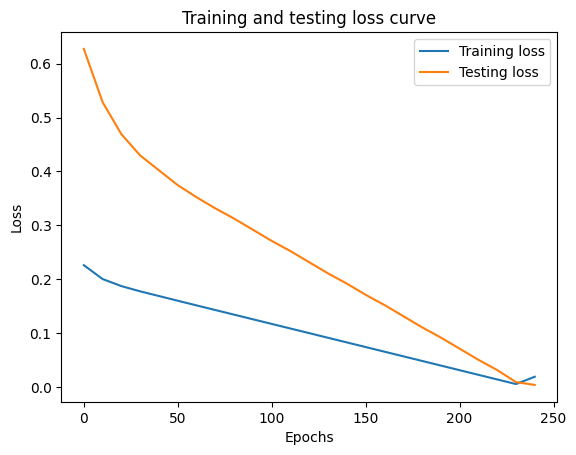

In [160]:
# Visualize the loss
import numpy as np
plt.plot(epoch_count,
         np.array(torch.tensor(train_loss_values).numpy()),
         label = "Training loss")
plt.plot(epoch_count,
         test_loss_values,
         label = "Testing loss")
plt.title("Training and testing loss curve")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()


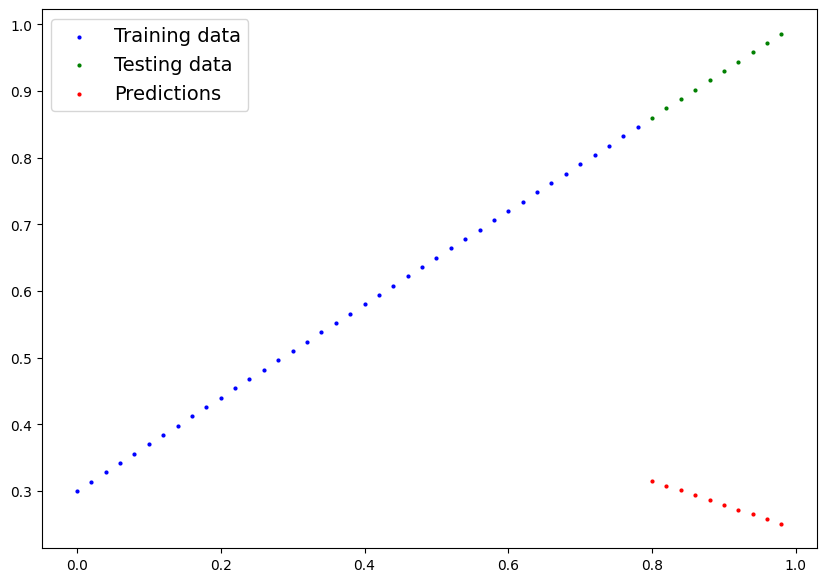

In [161]:
plot_predictions(predictions = y_preds)

In [162]:
with torch.inference_mode():
  y_preds_new = model_0(ytest)

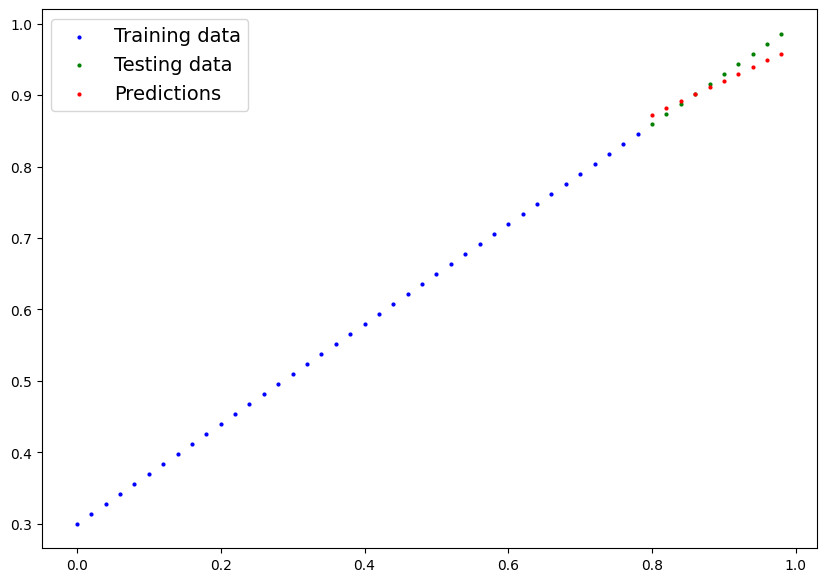

In [163]:
plot_predictions(predictions = y_preds_new)

In [164]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6783])), ('bias', tensor([0.2895]))])

##Saving a model in PyTorch

There are three main methods you should know about for saving and loading models in PyTorch.

1. `torch.save()` - allows you save a PyTorch in Python pickle format
2. `torch.load()` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

In [165]:
#Saving our PyTorch model
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_video.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving the model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving the model to: models/01_pytorch_workflow_video.pth


## Loading a PyTorch model

Since we saved our models`stat_dict()` rather the entire model, we'll creater a new instance fo our model class and `state_dict()` into that

In [166]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with uipdated parameter)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [167]:
loaded_model_0.state_dict()

OrderedDict([('weight', tensor([0.6783])), ('bias', tensor([0.2895]))])

In [168]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(Xtest)
loaded_model_preds

tensor([[0.8321],
        [0.8457],
        [0.8593],
        [0.8728],
        [0.8864],
        [0.9000],
        [0.9135],
        [0.9271],
        [0.9407],
        [0.9542]])

In [169]:
# compare loaded model preds with original model preds
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(Xtest)


In [170]:
loaded_model_preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together

In [171]:
import torch
from torch import nn
import matplotlib.pyplot as plt


# Check PyTorch version
torch.__version__

'2.1.0+cu121'

Create device-agnositc code

This means if we've got access to a GPU, our code will use it (for potentially faster computing)

If no GPU is available, the code will default to using CPU

In [172]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


### 6.1 Data

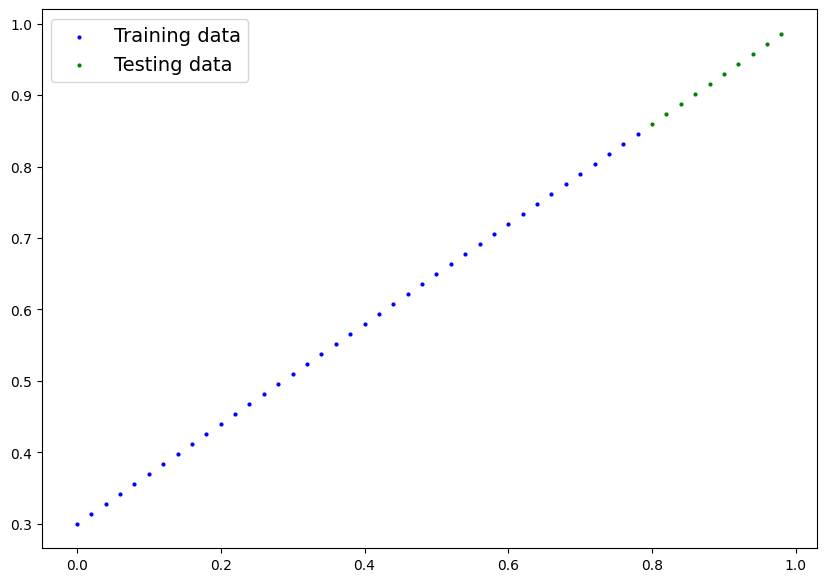

In [195]:
# Create some data using the linear regression formulal of y = weight * X + bias
weight = 0.7
bias = 0.3

# Create range value
start = 0
end = 1
step = 0.02

# Create X and y(feature)
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = X * weight + bias

# Split the dataset
split_value = int(len(X) * 0.8)
X_train,y_train = X[:split_value],y[:split_value]
X_test, y_test = X[split_value:],y[split_value]

# Visualaze
plot_predictions()

In [196]:
X_train

tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800],
        [0.2000],
        [0.2200],
        [0.2400],
        [0.2600],
        [0.2800],
        [0.3000],
        [0.3200],
        [0.3400],
        [0.3600],
        [0.3800],
        [0.4000],
        [0.4200],
        [0.4400],
        [0.4600],
        [0.4800],
        [0.5000],
        [0.5200],
        [0.5400],
        [0.5600],
        [0.5800],
        [0.6000],
        [0.6200],
        [0.6400],
        [0.6600],
        [0.6800],
        [0.7000],
        [0.7200],
        [0.7400],
        [0.7600],
        [0.7800]])

### 6.2 Buliding a PyTorch Linear model

In [197]:
from torch import nn

#create a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__ (self):
    super().__init__()
    #Use nn.Linear() for creating the model parameters
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)
  def forward(self, x:torch.Tensor) -> torch.Tensor:
    return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()



(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [198]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [199]:
# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training and testing model

* Loss functoin
* Optimizer
* Train loop
* Test loop

In [200]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.01)

torch.manual_seed(42)


In [201]:

# Put data on the target device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

epochs = 200

for epoch in range(epochs):
    ###Training
    model_1.train()

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate Loss
    train_loss = loss_fn(y_pred,y_train)

    # 3.
    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    ###Testing
    model_1.eval()
    with torch.inference_mode():
      test_pred = model_1(X_test)
      test_loss = loss_fn(test_pred, y_test)

    if epoch % 10 == 0:
      print(f"Epoch:{epoch} | Train Loss:{train_loss} | Test Loss:{test_loss}")


Epoch:0 | Train Loss:0.5551779866218567 | Test Loss:0.6369762420654297
Epoch:10 | Train Loss:0.439968079328537 | Test Loss:0.5022664070129395
Epoch:20 | Train Loss:0.3247582018375397 | Test Loss:0.3675565719604492
Epoch:30 | Train Loss:0.20954833924770355 | Test Loss:0.2328466922044754
Epoch:40 | Train Loss:0.09433845430612564 | Test Loss:0.09813689440488815
Epoch:50 | Train Loss:0.023886388167738914 | Test Loss:0.031217653304338455
Epoch:60 | Train Loss:0.019956795498728752 | Test Loss:0.03235740214586258
Epoch:70 | Train Loss:0.016517987474799156 | Test Loss:0.0362117700278759
Epoch:80 | Train Loss:0.013089174404740334 | Test Loss:0.0402032695710659
Epoch:90 | Train Loss:0.009653178043663502 | Test Loss:0.04571591690182686
Epoch:100 | Train Loss:0.006215683650225401 | Test Loss:0.05120285227894783
Epoch:110 | Train Loss:0.00278724217787385 | Test Loss:0.058129776269197464
Epoch:120 | Train Loss:0.0012645035749301314 | Test Loss:0.05183091759681702
Epoch:130 | Train Loss:0.00126450357

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


In [202]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### 6.5 Making prediciton and visualize the preformance

In [204]:
model_1.eval()
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds


tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

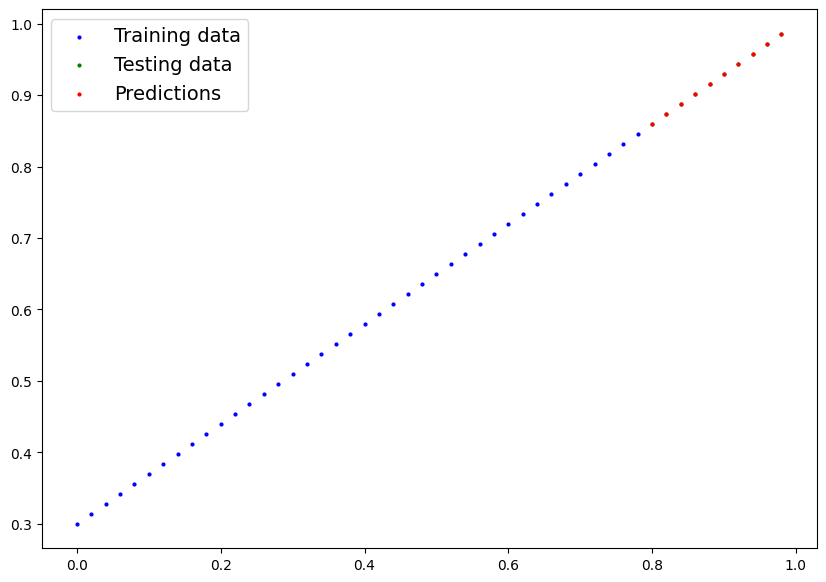

In [205]:
plot_predictions(predictions = y_preds.cpu())

### 6.6 Saving and Load trained model

In [210]:
### Saving model using `torch.save()`
from pathlib import Path

# 1.Create models directory

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. Create model save path
MODEL_NAME = "01_test_linearregression.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. preform saving operation
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

In [213]:
### Loading model using `torch.load()` and `torch.nn.Module.load_stat_dict()`
# Creaete a new instance of liner regression model v2
new_model = LinearRegressionModelV2()

#Load the saved model_1 state_dict
new_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH ))

# Put the loaded model to target device
new_model.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [214]:
next(new_model.parameters()).device

device(type='cuda', index=0)

In [217]:
with torch.inference_mode():
  loaded_pred = new_model(X_test)
loaded_pred == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')